In [1]:
import os, json, csv
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from tqdm.auto import tqdm

from transformers import (
    VisionEncoderDecoderModel,
    ViTFeatureExtractor,
    AutoTokenizer,
)
import matplotlib.pyplot as plt


In [2]:
model_name = 'nlpconnect/vit-gpt2-image-captioning'
images_dir = 'archive-3/images'
captions_file = 'archive-3/captions.txt'

subset_size = 8_000  # беру не весь датасет, чтобы было побыстрее
num_epochs = 3
batch_size = 16
lr = 5e-5
max_target_len = 32
image_size = 224
output_dir = 'vitgpt2_finetuned'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Path(output_dir).mkdir(parents=True, exist_ok=True)
print('Device:', device)

Device: cpu


In [3]:
class CaptionTxtDataset(Dataset):
    def __init__(self, images_dir, captions_file):
        self.images_dir = Path(images_dir)
        self.samples = []
        with open(captions_file, 'r', encoding='utf-8') as f:
            for line in f:
                if not line.strip():
                    continue
                img, cap = line.strip().split(',', 1)
                self.samples.append((img, cap))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, caption = self.samples[idx]
        image = Image.open(self.images_dir / img_name).convert('RGB')
        return {"image": image, "caption": caption}

In [6]:
import warnings

for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category=warn)

feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

dataset_full = CaptionTxtDataset(images_dir, captions_file)

# случайная подвыборка
indices = torch.randperm(len(dataset_full))[:subset_size]
train_dataset = Subset(dataset_full, indices)


def collate_fn(batch):
    images = [item["image"] for item in batch]
    captions = [item["caption"] for item in batch]

    pixel_values = feature_extractor(
        images,
        size=image_size,
        return_tensors='pt'
    ).pixel_values

    labels = tokenizer(
        captions,
        padding='max_length',
        max_length=max_target_len,
        truncation=True,
        return_tensors='pt'
    ).input_ids
    labels[labels == tokenizer.pad_token_id] = -100

    return {"pixel_values": pixel_values, "labels": labels}


train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

print(len(train_dataset), 'примеров,', len(train_loader), 'батчей на эпоху')


8000 примеров, 500 батчей на эпоху


In [7]:
model = VisionEncoderDecoderModel.from_pretrained(model_name)
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

for p in model.encoder.parameters():
    p.requires_grad_(False)

print('ViT-энкодер заморожен')

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

ViT-энкодер заморожен


In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
step_losses = []
epoch_losses = []

model.train()
for epoch in range(num_epochs):
    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
    epoch_sum = 0.0

    for step, batch in enumerate(pbar, 1):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        step_losses.append(loss.item())
        epoch_sum += loss.item()
        pbar.set_postfix({'loss': epoch_sum / step})

    mean_loss = epoch_sum / len(train_loader)
    epoch_losses.append(mean_loss)
    print(f'Epoch {epoch + 1}: mean loss = {mean_loss:.4f}')

Epoch 1/3:   0%|          | 0/500 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1: mean loss = 4.2180


Epoch 2/3:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2: mean loss = 3.6012


Epoch 3/3:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3: mean loss = 3.3209


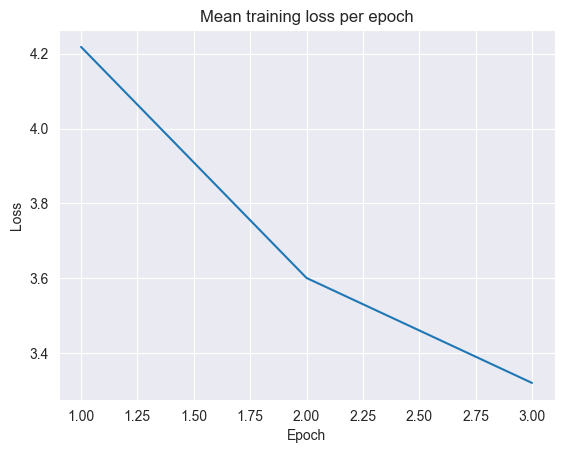

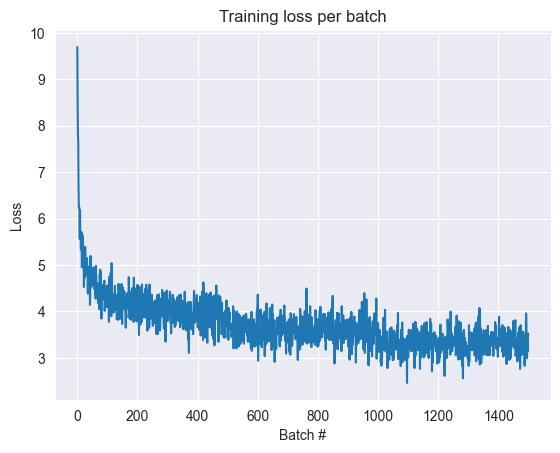

In [9]:
plt.figure()
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses)
plt.title('Mean training loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(step_losses)
plt.title('Training loss per batch')
plt.xlabel('Batch #')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

По графику видно, что модель быстро учится основам, дальше скорость улучшения падает. Есть смысл добавить еще эпох, но будет долго.

In [11]:
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print('Модель сохранена в', output_dir)

Модель сохранена в vitgpt2_finetuned


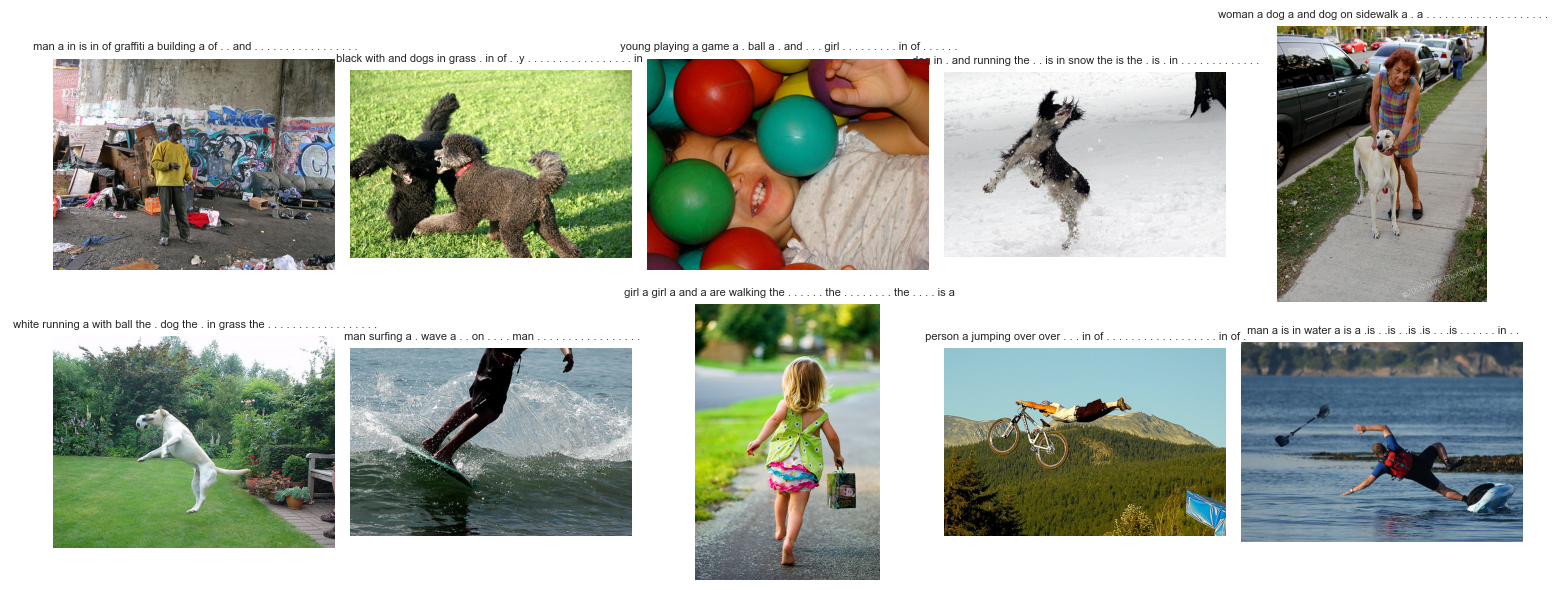

In [21]:
import random
from math import ceil

n_show = 10
sample_paths = random.sample(list(Path(images_dir).glob("*.jpg")), n_show)

# грузим изображения
imgs = [Image.open(p).convert("RGB") for p in sample_paths]

# батчевый генератор: так быстрее, чем по одной
pixel_vals = feature_extractor(
    imgs,
    size=image_size,
    return_tensors="pt"
).pixel_values.to(device)

gen_ids = model.generate(
    pixel_vals,
    max_length=max_target_len,
    num_beams=1,
    do_sample=False
)

captions = tokenizer.batch_decode(
    gen_ids, skip_special_tokens=True
)

cols = 5
rows = ceil(n_show / cols)
plt.figure(figsize=(cols * 3, rows * 3))

for i, (img, cap) in enumerate(zip(imgs, captions), 1):
    plt.subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(cap, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Выводы
Видим очень много повторов слов the, a, in, of и тп. Модель еще не до конца обучилась, но в целом смысл происходящего на картинке улавливается нормально, объекты везде распознаны верно, проблема только с грамматикой и построением осмысленной фразы. Мб есть смысл добавить beam-search, и дообучить на еще нескольких эпохах, с меньшим lr. Я брала не весь датасет, а только часть, есть смысл увеличить датасет, но будет долго.
